In [33]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from classy import Class

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

## Derive mass functions

In [38]:
mfk = MassFunctionKink()

In [39]:
n_B_list = [n_s, 1.5, 2., 3.]

In [40]:
CLASS_inst_list = []
for n_B in tqdm_notebook(n_B_list):
    CLASS_inst = mfk.get_CLASS_kink(k_B=10.,n_B=n_B)
    CLASS_inst_list.append(CLASS_inst)

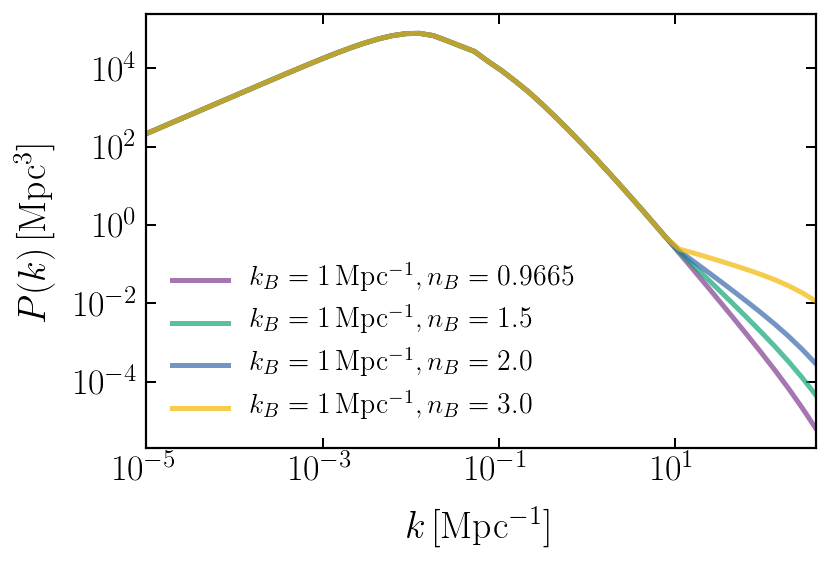

In [41]:
for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    k_ary = np.logspace(-5, np.log10(400))
    pk_ary = np.array([CLASS_inst.pk_lin(k,0) for k in k_ary])
    plt.plot(k_ary, pk_ary, label="$k_B=1\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$\,[Mpc$^{-1}$]")
plt.ylabel("$P(k)$\,[Mpc$^{3}$]")
plt.xlim(min(k_ary), max(k_ary))
plt.legend(fontsize=14)

In [42]:
def dn_dM_s(M_sc, CLASS_inst):
    R = (M_sc / (4 / 3. * np.pi * rho_m)) ** (1 / 3.)
    sigma = CLASS_inst.sigma(R / Mpc, 0) 
    sigma_log_deriv = np.abs(M_sc * derivative(lambda M: np.log(CLASS_inst.sigma((M / (4 / 3. * np.pi * rho_m)) ** (1 / 3.) / Mpc, 0)), x0=M_sc, dx=(0.9) * M_sc))
    return np.sqrt(2 / np.pi) * rho_m / M_sc ** 2 * delta_c / sigma * sigma_log_deriv * np.exp(-delta_c ** 2 / (2 * sigma ** 2))

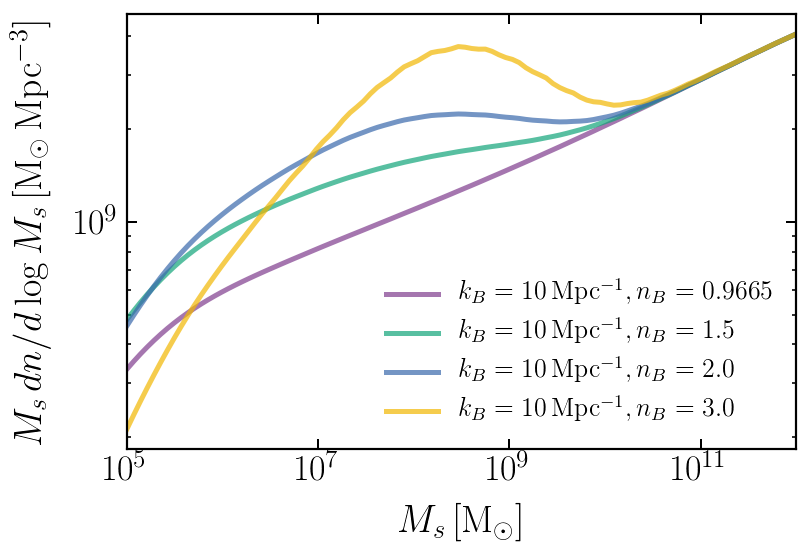

In [44]:
M_ary = np.logspace(5, 12, 100) * M_s

for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    plt.plot(M_ary / M_s, [M ** 2 * mfk.dn_dM_s(M, CLASS_inst) / (Mpc ** -3) / M_s for M in M_ary], label="$k_B=10\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$M_s$\,[M$_\odot$]")
plt.ylabel("$M_s\, dn/d\log M_s\,[\mathrm{M_\odot}$\,Mpc$^{-3}$]")
plt.xlim(min(M_ary / M_s), max(M_ary / M_s))
plt.legend(fontsize=13)

## Calibration

In [11]:
N_calib = 150.
pref = N_calib / quad(lambda M: dn_dM_s(M, CLASS_inst_list[0]), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]

In [12]:
N_calib_new = pref * quad(lambda M: dn_dM_s(M, CLASS_inst_list[3]), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-2)[0]

In [17]:
M_sc_calib = 1e11 * M_s
pspecpop = PowerSpectraPopulations(l_max=2000, CLASS_inst=CLASS_inst_list[3], fudge_factor_rho_s=1.)
rho_s_new = pspecpop.get_rs_rhos_NFW(M_sc_calib)[1]

In [18]:
from scipy.optimize import fsolve
M200 = 10 ** fsolve(lambda M200: np.log10(M_sc_calib / M_s) - np.log10(pspecpop.get_M_sc(10 ** M200 * M_s) / M_s), 9.)[0] * M_s
pspecpop = PowerSpectraPopulations(l_max=2000)
rho_s_old = pspecpop.get_rs_rhos_NFW(M200)[1]

In [21]:
fudge_factor_rho_s = rho_s_old / rho_s_new

## Sensitivity

In [23]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [24]:
pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e4*M_s, M_max=0.01*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu_notidal = pspecpop.get_C_l_total_ary();

In [25]:
M_ary = np.logspace(4, 12) * M_s
dndM_ary = np.array([dn_dM_s(M, CLASS_inst_list[3]) for M in M_ary])

dndM_interp = interp1d(np.log10(M_ary), np.log10(dndM_ary))

def dndM(M):
    return 10 ** dndM_interp(np.log10(M))

pspecpop = PowerSpectraPopulations(l_max=2000, CLASS_inst=CLASS_inst_list[3], fudge_factor_rho_s=fudge_factor_rho_s)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(dndM, M_min=1e4*M_s, M_max=0.01*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=N_calib_new)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu_new = pspecpop.get_C_l_total_ary()

In [26]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

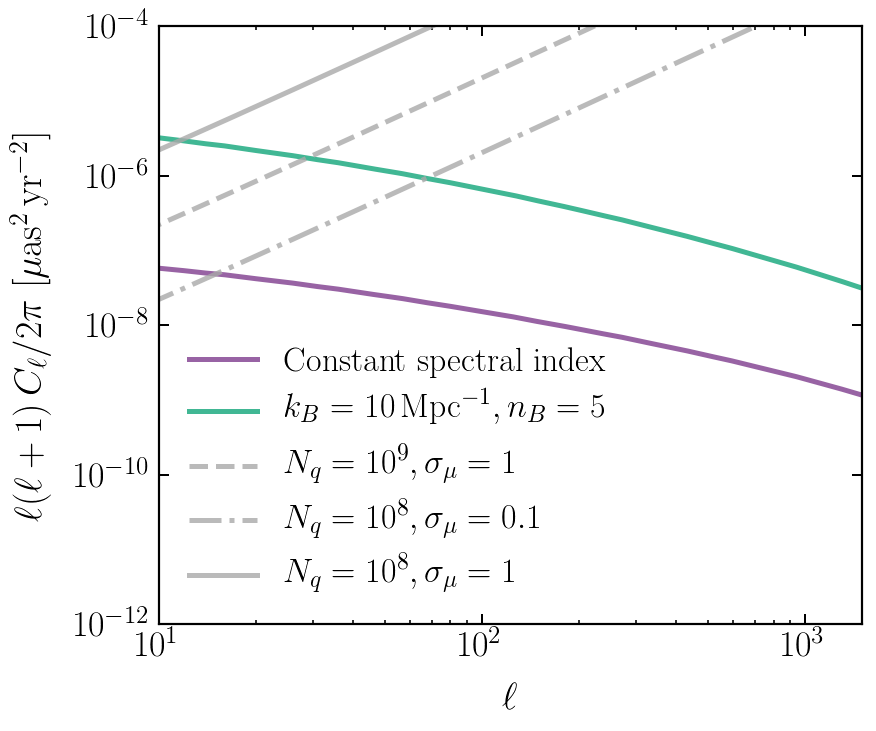

In [27]:
mpl.rcParams['figure.figsize'] = 6.3, 5.5

fig, ax = plt.subplots(1, 1)

c2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_notidal, label="Constant spectral index", alpha=alpha_plot, lw=lw_plot)
c3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_new, label="$k_B=10\,$Mpc$^{-1}, n_B=5$", alpha=alpha_plot, lw=lw_plot)

sigma_mu = 1
N_q = 1e9

l1 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = .1
N_q = 1e8

l2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 1
N_q = 1e8

l3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

plt.legend()

In [32]:
# Test

sigma_mu = 1.
sigma_alpha = .1
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = C_l_mu_new*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)
lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
print(lim)
baseline_sig = fDM_base/fshr.pars_vary[0].sigma
print(baseline_sig)

0.3063792020002479
5.352843761237661
